<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>MPO 624: MJO spectrum and significance testing</h1>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Is there a significant spectral peak? 
--------

In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal
from scipy.io import loadmat #This allows python to read a Matlab file

In [14]:
#Read in our timeseries
data = loadmat('/Users/newumuser/Documents/GitHub/DATA/rr_timeseries.mat')
coup_rr = data['coup_rr']
ctl_rr = data['ctl_rr']
lat = data['lat']
lon = data['lon']

lat_10 = lat[:,0]
lat_10_index = np.where((lat_10 <= 10) & (lat_10 >= -10))
lat_index = lat_10_index[0]

lon_60_90 = lon[0,:]
lon_60_90_index = np.where((lon_60_90 <= 90) & (lon_60_90 >= 60))
lon_index = lon_60_90_index[0]

coup_rr_less = coup_rr[:,lat_index[0]:lat_index[-1],lon_index[0]:lon_index[-1]] #only want rain over central Indian Ocean
coup_rr_less.shape

coup_rr_t = np.mean(np.mean(coup_rr_less,axis=1),axis=1)
coup_rr_t = coup_rr_t[:-1]

t = np.array(range(0,336))

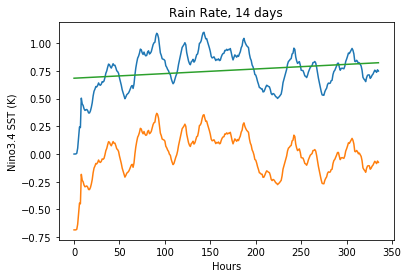

In [15]:
# Convert hours to days 
NYEAR = len(coup_rr_t)/24.
plt.plot(t,coup_rr_t)
plt.xlabel('Hours');plt.ylabel('Nino3.4 SST (K)')
plt.title('Rain Rate, 14 days')

plt.plot(t,signal.detrend(coup_rr_t))

plt.plot(t,coup_rr_t-signal.detrend(coup_rr_t))

----------------
<a name="spectrum"></a>
### Is there a "significant" periodicity to ENSO?

Let's look at the power spectrum

Variance is 0.03550591 (mm/h)^2: matches 0.03550590947270392
Detrended variance is 0.03387311 (mm/h)^2: matches 0.03387311100959779


Text(0.5,1,'Periodogram after detrending')

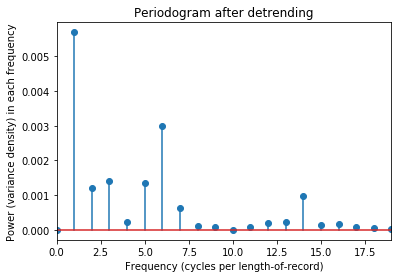

In [16]:
NT = len(coup_rr_t)

# Define the frequencies "freqs" (noting the symmetry -- but 0 occurs only at left)
freqs = np.array(range(NT))   # This gets the left end correct
reversed_freqs = freqs[::-1]  # Reverse the array 
reversed_freqs[0:int(NT/2)] = -freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
freqs = reversed_freqs[::-1]  # reverse it back 


# Variable V for the spectrum code
V = coup_rr_t

# Remove the mean, detrend
Vp = V - V.mean()
Vd = signal.detrend(Vp)
Vd = Vd - Vd.mean()

# Spectrum
Vspec = np.fft.fft( Vp )
Power = (Vspec.conjugate()*Vspec).real
Power *= np.var(Vp) / Power.sum()       # Enforce Parseval's theorem for variance 
print('Variance is', Vp.var(), '(mm/h)^2: matches', sum(Power))

# Detrended spectrum 
Vdspec = np.fft.fft( Vd )
Powerd = (Vdspec.conjugate()*Vdspec).real
Powerd *= np.var(Vd) / Powerd.sum()       # Enforce Parseval's theorem for variance 
print('Detrended variance is', Vd.var(), '(mm/h)^2: matches', sum(Powerd))

# Plot
fig,ax=plt.subplots(1,1) 
ax.stem(freqs, Powerd)

ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power (variance density) in each frequency')
ax.set_title('Periodogram after detrending')

## What was the detrending effect?

Text(0.5,1,'Periodogram difference due to detrending')

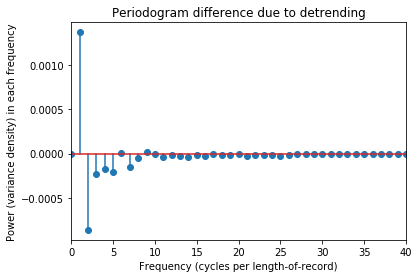

In [17]:
fig,ax=plt.subplots(1,1) 
ax.stem(freqs, Powerd-Power)

ax.set_xlim([0,40])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power (variance density) in each frequency')
ax.set_title('Periodogram difference due to detrending')

## Want more degrees of freedom per band? Rebin the spectrum

Text(0.5,1,'Periodogram rebinned by factor of 2')

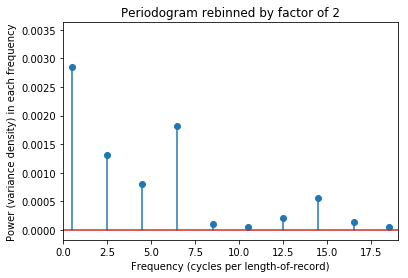

In [20]:
Pd2 = Powerd.reshape(int(NT/2),2).mean(1)
f2 = freqs.reshape(int(NT/2),2).mean(1)

fig,ax=plt.subplots(1,1) 
ax.stem(f2, Pd2)

ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power (variance density) in each frequency')
ax.set_title('Periodogram rebinned by factor of 2')

## Would that peak be hidden if we forgot to detrend?

Text(0.5,1,'Non-detrended (rebin factor 2)')

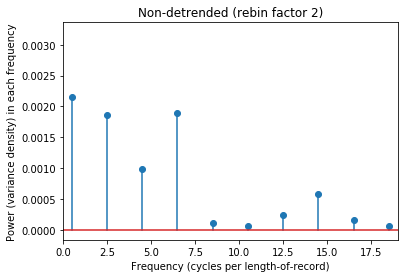

In [21]:
P2 = Power.reshape(int(NT/2),2).mean(1)
f2 = freqs.reshape(int(NT/2),2).mean(1) 

fig,ax=plt.subplots(1,1) 
ax.stem(f2, P2)

ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power (variance density) in each frequency')
ax.set_title('Non-detrended (rebin factor 2)')

------------

<a name='AR1'></a>
# Autoregression as a model for geophysical noise

# Postulate an "explanation" of RR by prior RR
$RR_t = intercept + c \cdot RR_{t-1} + residual_t$

Text(0.5,1,'RR and prior hour RR')

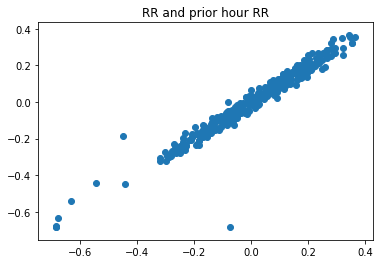

In [23]:
rr_t = signal.detrend(coup_rr_t)
rr_1 = np.roll(rr_t,-1) # same data rolled back one hour

fig,ax = plt.subplots(1,1)

ax.scatter(rr_t, rr_1)
ax.set_title('RR and prior hour RR')

In [24]:
import scipy, scipy.stats

slope, intercept, r_value, p_value, std_err = \
    scipy.stats.linregress(rr_t,rr_1)
    
Prediction = intercept + slope*rr_1
print( slope, intercept )
print("r-squared:", r_value**2)

0.9695864917825732 -6.474237131761932e-10
r-squared: 0.9400979650472379


In [25]:
resid = rr_t - Prediction

Text(0.5,1,'RR and residual of AR1 prediction')

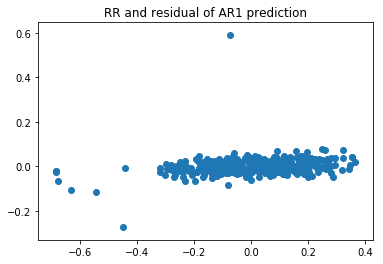

In [26]:
fig,ax = plt.subplots(1,1)

ax.scatter(rr_t, resid)
ax.set_title('RR and residual of AR1 prediction')

## Not a bad fit -- the residual has little relationship
### So we can model the residual with random noise 

In [27]:
sigma = np.std(resid)
FAKE_resid = np.random.randn( len(rr_t) )*sigma

# Make some fake data
FAKE = rr_t*0 + np.mean(rr_t) # right shaped container, mean value

for i in 1+np.arange(len(rr_t)-1): 
    FAKE[i] = intercept + slope*FAKE[i-1] + np.random.randn()*sigma

Text(0.5,1,'SST and AR1 noise')

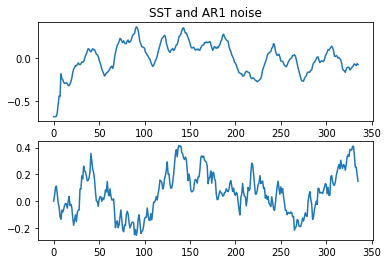

In [28]:
fig,ax =plt.subplots(2,1)
ax[0].plot(t, signal.detrend(coup_rr_t))
ax[1].plot(t, FAKE)
ax[0].set_title('SST and AR1 noise')

## Let's see the spectrum of the AR1 fake data

In [29]:
# Variable V for the spectrum code
V = FAKE

# Remove the mean, detrend
Vd = signal.detrend(V)
Vd = Vd - Vd.mean()

# Spectrum
Vspec = np.fft.fft( Vd )
Power = (Vspec.conjugate()*Vspec).real
Power *= np.var(Vd) / Power.sum()       # Enforce Parseval's theorem for variance 

Text(0.5,1,'RR and AR1 spectrum')

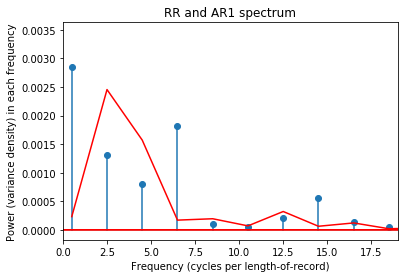

In [30]:
P2 = Power.reshape(int(NT/2),2).mean(1)

fig,ax=plt.subplots(1,1) 
ax.stem(f2, Pd2)
#ax.stem(f5, Pd5)

# Detrended Pd10 and rebinned AR1: a comparative view 
ax.plot(f2, P2, 'r')

ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power (variance density) in each frequency')
ax.set_title('RR and AR1 spectrum')

Text(0.5,1,'Variance ratio: for F test')

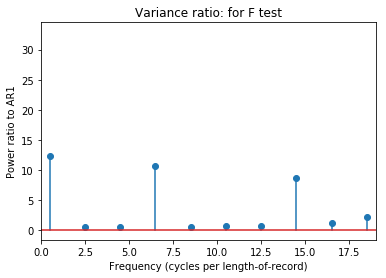

In [31]:
## Plot the ratio, for the F test 

fig,ax=plt.subplots(1,1) 
ax.stem(f2, Pd2/P2)

ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power ratio to AR1')
ax.set_title('Variance ratio: for F test')


## Need a less noisy AR1 spectrum: more instances

<Container object of 3 artists>

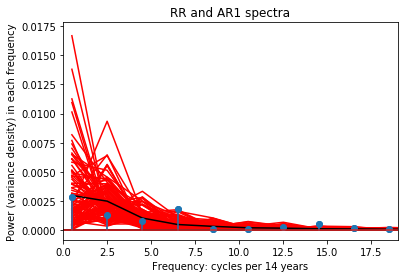

In [32]:
fig,ax=plt.subplots(1,1) 
ax.stem(f2, Pd2)
ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency: cycles per '+str(int(NYEAR))+' years')
ax.set_ylabel('Power (variance density) in each frequency')
ax.set_title('RR and AR1 spectra')

# Make MORE fake data
P2sum = P2 # sum up 100 values

for ifake in range(1, 100):
    FAKE = coup_rr_t*0 + np.mean(coup_rr_t) # right shaped container, mean value
    for i in 1+np.arange(len(coup_rr_t)-1): 
        FAKE[i] = intercept + slope*FAKE[i-1] + np.random.randn()*sigma
    
    V = FAKE
    Vd = signal.detrend(V)
    Vd = Vd - Vd.mean()

    # Spectrum
    Vspec = np.fft.fft( Vd )
    Power = (Vspec.conjugate()*Vspec).real
    Power *= np.var(Vd) / Power.sum()
    P2 = Power.reshape(int(NT/2),2).mean(1)
    P2sum += P2
    ax.plot(f2, P2, 'r')

P2red = P2sum/101
ax.plot(f2, P2red, 'k')
ax.stem(f2, Pd2)

Text(0.5,1,'Variance ratio: for F test')

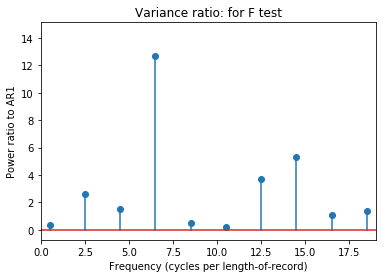

In [33]:
## Plot the ratio, for the F test 

fig,ax=plt.subplots(1,1) 
ax.stem(f2, Pd2/P2)

ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power ratio to AR1')
ax.set_title('Variance ratio: for F test')


https://en.wikipedia.org/wiki/F-test

## What if we didn't rebin frequency bands? 
### 2 DOF per frequency band instead of 20

<Container object of 3 artists>

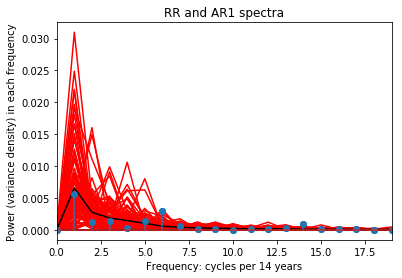

In [34]:
## How about raw? 
fig,ax=plt.subplots(1,1) 
ax.stem(freqs, Powerd)
ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency: cycles per '+str(int(NYEAR))+' years')
ax.set_ylabel('Power (variance density) in each frequency')
ax.set_title('RR and AR1 spectra')

# Make MORE fake data
Psum = Power # sum up 100 values

for ifake in range(1, 100):
    FAKE = coup_rr_t*0 + np.mean(coup_rr_t) # right shaped container, mean value
    for i in 1+np.arange(len(coup_rr_t)-1): 
        FAKE[i] = intercept + slope*FAKE[i-1] + np.random.randn()*sigma
    
    V = FAKE
    Vd = signal.detrend(V)
    Vd = Vd - Vd.mean()

    # Spectrum
    Vspec = np.fft.fft( Vd )
    Power = (Vspec.conjugate()*Vspec).real
    Power *= np.var(Vd) / Power.sum()
    Psum += Power
    ax.plot(freqs, Power, 'r')

Pred = Psum/101
ax.plot(freqs, Pred, 'k')
ax.stem(freqs, Powerd)

Text(0.5,1,'Variance ratio: for F test')

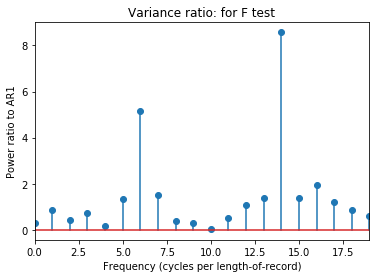

In [35]:
## Plot the ratio, for the F test 

fig,ax=plt.subplots(1,1) 
ax.stem(freqs, Powerd/Pred)

ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power ratio to AR1')
ax.set_title('Variance ratio: for F test')
